In [1]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from datasets import Datasets
import numpy as np
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.autograd import Function
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

## Model

In [2]:
class Analysis_transform(nn.Module):
    def __init__(self, num_filters=128):
        super(Analysis_transform, self).__init__()
        # i = 0
        self.b0_shortcut = nn.Conv2d(3, num_filters, 1, stride=2)
        self.b0_layer2 = nn.Conv2d(3, num_filters, 3, stride=2, padding=1)
        self.b0_layer2_relu = nn.LeakyReLU()
        self.b0_layer3 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b0_layer3_GDN = GDN(num_filters)

        # i = 1
        self.b1_layer0 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer0_relu = nn.LeakyReLU()
        self.b1_layer1 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer1_relu = nn.LeakyReLU()
        self.b1_shortcut = nn.Conv2d(num_filters, num_filters, 1, stride=2)
        self.b1_layer2 = nn.Conv2d(num_filters, num_filters, 3, stride=2, padding=1)
        self.b1_layer2_relu = nn.LeakyReLU()
        self.b1_layer3 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer3_GDN = GDN(num_filters)
        self.attention1 = Attention(num_filters)

        # i = 2
        self.b2_layer0 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer0_relu = nn.LeakyReLU()
        self.b2_layer1 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer1_relu = nn.LeakyReLU()
        self.b2_shortcut = nn.Conv2d(num_filters, num_filters, 1, stride=2)
        self.b2_layer2 = nn.Conv2d(num_filters, num_filters, 3, stride=2, padding=1)
        self.b2_layer2_relu = nn.LeakyReLU()
        self.b2_layer3 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer3_GDN = GDN(num_filters)

        # i = 3
        self.b3_layer0 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b3_layer0_relu = nn.LeakyReLU()
        self.b3_layer1 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b3_layer1_relu = nn.LeakyReLU()
        self.b3_layer2 = nn.Conv2d(num_filters, num_filters, 3, stride=2, padding=1, bias=False)
        self.attention2 = Attention(num_filters)


    def forward(self, x):
        # i = 0
        shortcut0 = self.b0_shortcut(x)#[1,3,H,W]->[1,128,H/2,H/2]
        b0 = self.b0_layer2(x)#[1,3,H,W]->[1,128,H/2,H/2]
        b0 = self.b0_layer2_relu(b0)
        b0 = self.b0_layer3(b0)
        b0 = self.b0_layer3_GDN(b0)
        b0 += shortcut0

        # i = 1
        b1 = self.b1_layer0(b0)#[1,128,H/2,H/2]->[1,128,H/2,H/2]
        b1 = self.b1_layer0_relu(b1)
        b1 = self.b1_layer1(b1)
        b1 = self.b1_layer1_relu(b1)
        b1 += b0
        shortcut1 = self.b1_shortcut(b1)#[1,128,H/2,H/2]->[1,128,H/4,H/4]
        b1 = self.b1_layer2(b1)#//2
        b1 = self.b1_layer2_relu(b1)
        b1 = self.b1_layer3(b1)
        b1 = self.b1_layer3_GDN(b1)
        b1 += shortcut1
        b1 = self.attention1(b1)

        # i = 2
        b2 = self.b2_layer0(b1)
        b2 = self.b2_layer0_relu(b2)
        b2 = self.b2_layer1(b2)
        b2 = self.b2_layer1_relu(b2)
        b2 += b1
        shortcut2 = self.b2_shortcut(b2)
        b2 = self.b2_layer2(b2)#//2
        b2 = self.b2_layer2_relu(b2)
        b2 = self.b2_layer3(b2)
        b2 = self.b2_layer3_GDN(b2)
        b2 += shortcut2

        # i = 3
        b3 = self.b3_layer0(b2)
        b3 = self.b3_layer0_relu(b3)
        b3 = self.b3_layer1(b3)
        b3 = self.b3_layer1_relu(b3)
        b3 += b2
        b3 = self.b3_layer2(b3)
        b3 = self.attention2(b3)

        return b3#(B,128,H/16,W/16)


class MaskedConv2d(nn.Conv2d):
    '''
    clone this function from https://github.com/thekoshkina/learned_image_compression/blob/master/masked_conv.py
    Implementation of the Masked convolution from the paper
    Van den Oord, Aaron, et al. "Conditional image generation with pixelcnn decoders."
    Advances in neural information processing systems. 2016.
    https://arxiv.org/pdf/1606.05328.pdf
    '''

    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
       
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
   
        self.weight.data *= self.mask
   
        return super(MaskedConv2d, self).forward(x)


class Hyper_synthesis(nn.Module):
    def __init__(self, num_filters=128):
        super(Hyper_synthesis, self).__init__()
        self.conv1 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.leaky_relu1 = nn.LeakyReLU()
        self.conv2 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.leaky_relu2 = nn.LeakyReLU()
        self.conv3 = nn.ConvTranspose2d(num_filters, int(num_filters*1.5), 3, stride=1, padding=1)
        self.leaky_relu3 = nn.LeakyReLU()
        self.conv4 = nn.ConvTranspose2d(int(num_filters*1.5), int(num_filters*1.5), 3, stride=2, padding=1, output_padding=1)
        self.leaky_relu4 = nn.LeakyReLU()
        # self.conv5 = nn.ConvTranspose2d(int(num_filters*1.5), num_filters*2, 3, stride=1, padding=1)
        self.conv5 = nn.ConvTranspose2d(int(num_filters*1.5), num_filters*2, 3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.leaky_relu1(self.conv1(x))
        x = self.leaky_relu2(self.conv2(x))#(B,128,H/64,W/64)->(B,128,H/32,W/32)
        x = self.leaky_relu3(self.conv3(x))
        x = self.leaky_relu4(self.conv4(x))
        x = self.conv5(x)
        return x

class Entropy(nn.Module):#无损压缩代码
    def __init__(self, num_filters=128):
        super(Entropy, self).__init__()
        self.maskedconv = MaskedConv2d('A', num_filters, num_filters*2, 5, stride=1, padding=2)
        # torch.nn.init.xavier_normal_(self.maskedconv.weight.data, (math.sqrt(2 / (num_filters + num_filters*2))))
        torch.nn.init.xavier_uniform_(self.maskedconv.weight.data, gain=1)
        torch.nn.init.constant_(self.maskedconv.bias.data, 0.0)
        self.conv1 = nn.Conv2d(num_filters*4, 640, 1, stride=1)
        self.leaky_relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(640, 640, 1, stride=1)
        self.leaky_relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(640, num_filters*9, 1, stride=1, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sigma, y):
        y = self.maskedconv(y)
        # print(y.shape)
        x = torch.cat([y, sigma], dim=1)
        # print(x.shape)
        x = self.leaky_relu1(self.conv1(x))
        x = self.leaky_relu2(self.conv2(x))
        x = self.conv3(x)
        # print("split_size: ", x.shape[1])
        prob0, mean0, scale0, prob1, mean1, scale1, prob2, mean2, scale2 = \
            torch.split(x, split_size_or_sections=int(x.shape[1]/9), dim=1)
        scale0 = torch.abs(scale0)
        scale1 = torch.abs(scale1)
        scale2 = torch.abs(scale2)
        probs = torch.stack([prob0, prob1, prob2], dim=-1)
        # print("probs shape: ", probs.shape)
        probs = self.softmax(probs)
        # probs = torch.nn.Softmax(dim=-1)(probs)
        means = torch.stack([mean0, mean1, mean2], dim=-1)
        variances = torch.stack([scale0, scale1, scale2], dim=-1)

        return means, variances, probs

class Synthesis_transform(nn.Module):
    def __init__(self, num_filters=128):
        super(Synthesis_transform, self).__init__()
        # i = 0
        self.attention1 = Attention(num_filters)
        self.b0_layer0 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b0_layer0_relu = nn.LeakyReLU()
        self.b0_layer1 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b0_layer1_relu = nn.LeakyReLU()
        self.b0_shortcut = nn.ConvTranspose2d(num_filters, num_filters, 1, stride=2, output_padding=1)
        self.b0_layer2 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.b0_layer2_relu = nn.LeakyReLU()
        self.b0_layer3 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b0_layer3_igdn = GDN(num_filters, inverse=True)

        # i = 1
        self.b1_layer0 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer0_relu = nn.LeakyReLU()
        self.b1_layer1 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer1_relu = nn.LeakyReLU()
        self.b1_shortcut = nn.ConvTranspose2d(num_filters, num_filters, 1, stride=2, output_padding=1)
        self.b1_layer2 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.b1_layer2_relu = nn.LeakyReLU()
        self.b1_layer3 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b1_layer3_igdn = GDN(num_filters, inverse=True)

        # i = 2
        self.attention2 = Attention(num_filters)
        self.b2_layer0 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer0_relu = nn.LeakyReLU()
        self.b2_layer1 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer1_relu = nn.LeakyReLU()
        self.b2_shortcut = nn.ConvTranspose2d(num_filters, num_filters, 1, stride=2, output_padding=1)
        self.b2_layer2 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=2, padding=1, output_padding=1)
        self.b2_layer2_relu = nn.LeakyReLU()
        self.b2_layer3 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b2_layer3_igdn = GDN(num_filters, inverse=True)

        # i = 3
        self.b3_layer0 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b3_layer0_relu = nn.LeakyReLU()
        self.b3_layer1 = nn.ConvTranspose2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.b3_layer1_relu = nn.LeakyReLU()
        self.b3_layer2 = nn.ConvTranspose2d(num_filters, 3, 3, stride=2, padding=1, output_padding=1)



    def forward(self, x):
        # i = 0
        attention0 = self.attention1(x)
        b0 = self.b0_layer0_relu(self.b0_layer0(attention0))
        b0 = self.b0_layer1_relu(self.b0_layer1(b0))
        b0 += attention0
        shortcut0 = self.b0_shortcut(b0)
        b0 = self.b0_layer2_relu(self.b0_layer2(b0))
        b0 = self.b0_layer3_igdn(self.b0_layer3(b0))
        b0 += shortcut0

        # i = 1
        b1 = self.b1_layer0_relu(self.b1_layer0(b0))
        b1 = self.b1_layer1_relu(self.b1_layer1(b1))
        b1 += b0
        shortcut1 = self.b1_shortcut(b1)
        b1 = self.b1_layer2_relu(self.b1_layer2(b1))
        b1 = self.b1_layer3_igdn(self.b1_layer3(b1))
        b1 += shortcut1

        # i = 2
        attention2 = self.attention2(b1)
        b2 = self.b2_layer0_relu(self.b2_layer0(attention2))
        b2 = self.b2_layer1_relu(self.b2_layer1(b2))
        b2 += attention2
        shortcut2 = self.b2_shortcut(b2)
        b2 = self.b2_layer2_relu(self.b2_layer2(b2))
        b2 = self.b2_layer3_igdn(self.b2_layer3(b2))
        b2 += shortcut2

        # i = 3
        b3 = self.b3_layer0_relu(self.b3_layer0(b2))
        b3 = self.b3_layer1_relu(self.b3_layer1(b3))
        b3 += b2
        b3 = self.b3_layer2(b3)

        return b3


class Bitparm(nn.Module):
    '''
    save params
    '''
    def __init__(self, channel, final=False):
        super(Bitparm, self).__init__()
        self.final = final
        self.h = nn.Parameter(torch.nn.init.normal_(torch.empty(channel).view(1, -1, 1, 1), 0, 0.01))
        self.b = nn.Parameter(torch.nn.init.normal_(torch.empty(channel).view(1, -1, 1, 1), 0, 0.01))
        if not final:
            self.a = nn.Parameter(torch.nn.init.normal_(torch.empty(channel).view(1, -1, 1, 1), 0, 0.01))
        else:
            self.a = None

    def forward(self, x):
        if self.final:
            return torch.sigmoid(x * F.softplus(self.h) + self.b)
        else:
            x = x * F.softplus(self.h) + self.b
            return x + torch.tanh(x) * torch.tanh(self.a)

class BitEstimator(nn.Module):
    '''
    Estimate bit
    '''
    def __init__(self, channel):
        super(BitEstimator, self).__init__()
        self.f1 = Bitparm(channel)
        self.f2 = Bitparm(channel)
        self.f3 = Bitparm(channel)
        self.f4 = Bitparm(channel, True)
        
    def forward(self, x):
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return self.f4(x)
    
class Hyper_analysis(nn.Module):
    def __init__(self, num_filters=128):
        super(Hyper_analysis, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.leaky_relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.leaky_relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(num_filters, num_filters, 3, stride=2, padding=1)
        self.leaky_relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(num_filters, num_filters, 3, stride=1, padding=1)
        self.leaky_relu4 = nn.LeakyReLU()
        self.conv5 = nn.Conv2d(num_filters, num_filters, 3, stride=2, padding=1)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        # print(x.shape)
        x = self.leaky_relu2(self.conv2(x))
        # print(x.shape)
        x = self.leaky_relu3(self.conv3(x))#(B,128,H/32,W/32)
        # print(x.shape)
        x = self.leaky_relu4(self.conv4(x))
        # print(x.shape)
        x = self.conv5(x)#(B,128,H/56,W/56)
        # print(x.shape)
        return x
    
    
class LowerBound(Function):
    @staticmethod
    def forward(ctx, inputs, bound):
        b = torch.ones_like(inputs) * bound
        ctx.save_for_backward(inputs, b)
        return torch.max(inputs, b)
        
    @staticmethod
    def backward(ctx, grad_output):
        inputs, b = ctx.saved_tensors
        pass_through_1 = inputs >= b
        pass_through_2 = grad_output < 0

        pass_through = pass_through_1 | pass_through_2
        return pass_through.type(grad_output.dtype) * grad_output, None
    

class GDN(nn.Module):
    """Generalized divisive normalization layer.
    y[i] = x[i] / sqrt(beta[i] + sum_j(gamma[j, i] * x[j]))
    """

    def __init__(self,
                 ch,
                 inverse=False,
                 beta_min=1e-6,
                 gamma_init=0.1,
                 reparam_offset=2**-18):
        super(GDN, self).__init__()
        self.inverse = inverse
        self.beta_min = beta_min
        self.gamma_init = gamma_init
        self.reparam_offset = reparam_offset

        self.build(ch)

    def build(self, ch):
        self.pedestal = self.reparam_offset**2
        self.beta_bound = ((self.beta_min + self.reparam_offset**2)**0.5)
        self.gamma_bound = self.reparam_offset

        # Create beta param
        beta = torch.sqrt(torch.ones(ch)+self.pedestal)
        self.beta = nn.Parameter(beta)

        # Create gamma param
        eye = torch.eye(ch)
        g = self.gamma_init*eye
        g = g + self.pedestal
        gamma = torch.sqrt(g)

        self.gamma = nn.Parameter(gamma)
        self.pedestal = self.pedestal

    def forward(self, inputs):
        unfold = False
        if inputs.dim() == 5:
            unfold = True
            bs, ch, d, w, h = inputs.size() 
            inputs = inputs.view(bs, ch, d*w, h)

        _, ch, _, _ = inputs.size()

        # Beta bound and reparam
        beta = LowerBound.apply(self.beta, self.beta_bound)
        beta = beta**2 - self.pedestal

        # Gamma bound and reparam
        gamma = LowerBound.apply(self.gamma, self.gamma_bound)
        gamma = gamma**2 - self.pedestal
        gamma = gamma.view(ch, ch, 1, 1)

        # Norm pool calc
        norm_ = nn.functional.conv2d(inputs**2, gamma, beta)
        norm_ = torch.sqrt(norm_)

        # Apply norm
        if self.inverse:
            outputs = inputs * norm_
        else:
            outputs = inputs / norm_

        if unfold:
            outputs = outputs.view(bs, ch, d, w, h)
        return outputs

class ResBlock(nn.Module):
    def __init__(self, num_filters=128):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters//2, 1, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_filters//2, num_filters//2, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(num_filters//2, num_filters, 1, stride=1)

    def forward(self, x):
        res = self.relu1(self.conv1(x))
        res = self.relu2(self.conv2(res))
        res = self.conv3(res)
        res += x
        return res
    
class Attention(nn.Module):
    def __init__(self, num_filters=128):
        super(Attention, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, 1, stride=1)
        self.sigmoid = nn.Sigmoid()
        self.trunk_ResBlock1 = ResBlock(num_filters)
        self.trunk_ResBlock2 = ResBlock(num_filters)
        self.trunk_ResBlock3 = ResBlock(num_filters)
        self.attention_ResBlock1 = ResBlock(num_filters)
        self.attention_ResBlock2 = ResBlock(num_filters)
        self.attention_ResBlock3 = ResBlock(num_filters)
    
    def forward(self, x):
        trunk_branch = self.trunk_ResBlock1(x)
        trunk_branch = self.trunk_ResBlock2(trunk_branch)
        trunk_branch = self.trunk_ResBlock3(trunk_branch)

        attention_branch = self.attention_ResBlock1(x)
        attention_branch = self.attention_ResBlock2(attention_branch)
        attention_branch = self.attention_ResBlock3(attention_branch)
        attention_branch = self.conv1(attention_branch)
        attention_branch = self.sigmoid(attention_branch)

        # print("x.shape: ", x.shape)
        # print("attention.shape: ", attention_branch.shape)
        # print("trunk_branch.shape: ", trunk_branch.shape)
        result = x + torch.mul(attention_branch, trunk_branch)
        return result


def quantize(vector: torch.Tensor, qb: int) -> torch.Tensor:
    # return (vector * (2 ** qb) + 0.5).to(torch.int64)
    return torch.round(vector * (2 ** qb) + 0.5)
    
def dequantize(vector: torch.Tensor, qb: int) -> torch.Tensor:
    return vector.float() / (2 ** qb)

In [48]:
import typing as tp
class ImageCompressor(nn.Module):
    def __init__(self, out_channel_N=128,B=2):
    # def __init__(self, out_channel_N=192, out_channel_M=320):
        super(ImageCompressor, self).__init__()
        self.Encoder = Analysis_transform(out_channel_N)
        self.Decoder = Synthesis_transform(out_channel_N)
        self.priorEncoder = Hyper_analysis(out_channel_N)
        self.priorDecoder = Hyper_synthesis(out_channel_N)
        self.bitEstimator_z = BitEstimator(out_channel_N)
        self.entropy = Entropy(out_channel_N)
        self.out_channel_N = out_channel_N
        self.B=B
        # self.out_channel_M = out_channel_M

    def forward(self, input_image):
        scale=2**-self.B
        quant_noise_feature = torch.zeros(input_image.size(0), self.out_channel_N, input_image.size(2) // 16, input_image.size(3) // 16).cuda()#H//6
        quant_noise_z = torch.zeros(input_image.size(0), self.out_channel_N, input_image.size(2) // 64, input_image.size(3) // 64).cuda()#H//64
        quant_noise_feature = torch.nn.init.uniform_(torch.zeros_like(quant_noise_feature), -0.5, 0.5) * scale#均匀分布 -0.5, 0.5,shape=H/6
        quant_noise_z = torch.nn.init.uniform_(torch.zeros_like(quant_noise_z), -0.5, 0.5) * scale
        feature = self.Encoder(input_image)
        batch_size = feature.size()[0]

        z = self.priorEncoder(feature)
        if self.training:
            compressed_z = z + quant_noise_z
        else:
            # compressed_z = torch.round(z)
            #----------------------------
            compressed_z=quantize(z,self.B)
            
        #----
        if not self.training:
            compressed_z = dequantize(compressed_z, self.B)
        #----
        
        phi = self.priorDecoder(compressed_z)
        feature_renorm = feature
        if self.training:
            compressed_feature_renorm = feature_renorm + quant_noise_feature
        else:
            # compressed_feature_renorm = torch.round(feature_renorm) #到最近的整数
            #-----
            compressed_feature_renorm=quantize(feature_renorm,self.B)

        
        
        
        #------------Add mask conv---------------
        # compressed_feature use mask
        means, sigmas, weights = self.entropy(phi, compressed_feature_renorm)
        
        #----
        if not self.training:
            compressed_feature_renorm = dequantize(compressed_feature_renorm, self.B)
        #----
        
        
        recon_image = self.Decoder(compressed_feature_renorm)

        # recon_image = prediction + recon_res
        clipped_recon_image = recon_image.clamp(0., 1.)

        
        
        # distortion
        mse_loss = torch.mean((recon_image - input_image).pow(2))
        im_shape = input_image.size()

        def feature_probs_based_sigma(feature, mu, sigma):
            # mu = torch.zeros_like(sigma)
            sigma = sigma.clamp(1e-10, 1e10)
            gaussian = torch.distributions.laplace.Laplace(mu, sigma)
            probs = gaussian.cdf(feature + 0.5) - gaussian.cdf(feature - 0.5)
            total_bits = torch.sum(torch.clamp(-1.0 * torch.log(probs + 1e-10) / math.log(2.0), 0, 50))
            return total_bits, probs
       
        def feature_probs_based_GMM(feature, means, sigmas, weights):
            mean1 = torch.squeeze(means[:,:,:,:,0])
            mean2 = torch.squeeze(means[:,:,:,:,1])
            mean3 = torch.squeeze(means[:,:,:,:,2])
            sigma1 = torch.squeeze(sigmas[:,:,:,:,0])
            sigma2 = torch.squeeze(sigmas[:,:,:,:,1])
            sigma3 = torch.squeeze(sigmas[:,:,:,:,2])

            weight1, weight2, weight3 = torch.squeeze(weights[:,:,:,:,0]), torch.squeeze(weights[:,:,:,:,1]), torch.squeeze(weights[:,:,:,:,2])
            # sigma1, sigma2, sigma3 = sigma1.clamp(1e-10, 1e10), sigma2.clamp(1e-10, 1e10), sigma3.clamp(1e-10, 1e10)
            gaussian1 = torch.distributions.laplace.Laplace(mean1, sigma1)
            gaussian2 = torch.distributions.laplace.Laplace(mean2, sigma2)
            gaussian3 = torch.distributions.laplace.Laplace(mean3, sigma3)
            prob1 = gaussian1.cdf(feature + 0.5) - gaussian1.cdf(feature - 0.5)
            prob2 = gaussian2.cdf(feature + 0.5) - gaussian2.cdf(feature - 0.5)
            prob3 = gaussian3.cdf(feature + 0.5) - gaussian3.cdf(feature - 0.5)

            probs = weight1 * prob1 + weight2 * prob2 + weight3 * prob3
            total_bits = torch.sum(torch.clamp(-1.0 * torch.log(probs + 1e-10) / math.log(2.0), 0, 50))
            return total_bits, probs
 
            

        def iclr18_estimate_bits_z(z):
            prob = self.bitEstimator_z(z + 0.5) - self.bitEstimator_z(z - 0.5)
            total_bits = torch.sum(torch.clamp(-1.0 * torch.log(prob + 1e-10) / math.log(2.0), 0, 50))
            return total_bits, prob

       
        # total_bits_feature, _ = feature_probs_based_sigma(compressed_feature_renorm, recon_sigma)
        try:
            total_bits_feature, _ = feature_probs_based_GMM(compressed_feature_renorm, means, sigmas, weights)
            total_bits_z, _ = iclr18_estimate_bits_z(compressed_z)
        except:
            total_bits_feature=0
            total_bits_z=0
        # im_shape = input_image.size()
        bpp_feature = total_bits_feature / (batch_size * im_shape[2] * im_shape[3])
        bpp_z = total_bits_z / (batch_size * im_shape[2] * im_shape[3])
        bpp = bpp_feature + bpp_z
        return clipped_recon_image, mse_loss, bpp_feature, bpp_z, bpp

   
def feature_probs_based_More_Gauss(feature, means, sigmas, weights):
    # Calculate the pmf/cdf
    mean1 = torch.squeeze(means[:,:,:,:,0])
    print("mean1:", mean1.shape)
    mean2 = torch.squeeze(means[:,:,:,:,1])
    mean3 = torch.squeeze(means[:,:,:,:,2])
    sigma1 = torch.squeeze(sigmas[:,:,:,:,0])
    sigma2 = torch.squeeze(sigmas[:,:,:,:,1])
    sigma3 = torch.squeeze(sigmas[:,:,:,:,2])
    weight1, weight2, weight3 = torch.squeeze(weights[:,:,:,:,0]),torch.squeeze(weights[:,:,:,:,1]),torch.squeeze(weights[:,:,:,:,2])
    sigma1, sigma2, sigma3 = sigma1.clamp(1e-10, 1e10), sigma2.clamp(1e-10, 1e10), sigma3.clamp(1e-10, 1e10)
    gaussian1 = torch.distributions.laplace.Laplace(mean1, sigma1)
    gaussian2 = torch.distributions.laplace.Laplace(mean2, sigma2)
    gaussian3 = torch.distributions.laplace.Laplace(mean3, sigma3)
    prob1 = gaussian1.cdf(feature + 0.5) - gaussian1.cdf(feature - 0.5)
    prob2 = gaussian2.cdf(feature + 0.5) - gaussian2.cdf(feature - 0.5)
    prob3 = gaussian3.cdf(feature + 0.5) - gaussian3.cdf(feature - 0.5)
    # testweight = weight1 + weight2 + weight3
    # print("testweight: ", testweight)
    probs = weight1 * prob1 + weight2 * prob2 + weight3 * prob3
    total_bits = torch.sum(torch.clamp(-1.0 * torch.log(probs + 1e-10) / math.log(2.0), 0, 50))
    return total_bits, probs

def feature_probs_based_sigma(feature, sigma):
        mu = torch.zeros_like(sigma)
        sigma = sigma.clamp(1e-10, 1e10)
        gaussian1 = torch.distributions.laplace.Laplace(mu, sigma)
        gaussian2 = torch.distributions.laplace.Laplace(mu, sigma)
        # gaussian = gaussian1 + gaussian2
        print("gaussian: ", gaussian1)
        probs = gaussian1.cdf(feature + 0.5) - gaussian1.cdf(feature - 0.5)
        total_bits = torch.sum(torch.clamp(-1.0 * torch.log(probs + 1e-10) / math.log(2.0), 0, 50))
        return total_bits, probs

def test_gaussian():
    mu = 0
    sigma = 0.5
    gaussian = torch.distributions.laplace.Laplace(mu, sigma)
    probs = gaussian.cdf(0.5) - gaussian.cdf(-0.5)
    print(probs)



## Parameters

In [4]:
out_channel_N=192
out_channel_M= 192
cur_lr = base_lr = 1e-4
lr= {
    "base": 0.0001,
    "decay": 0.1,
    "decay_interval": 920000
}
batch_size=16
train_lambda = 128
image_size = 256
LOG_INTERVAL= 500
B_list=[2,4,8]



## Create dataset

In [5]:
from torch.utils.data.dataset import Dataset
from glob import glob
class Datasets(Dataset):
    def __init__(self, data_dir, image_size=256):
        self.data_dir = data_dir
        self.image_size = image_size

        if not os.path.exists(data_dir):
            raise Exception(f"[!] {self.data_dir} not exitd")

        self.image_path = sorted(glob(os.path.join(self.data_dir, "*.*")))

    def __getitem__(self, item):
        image_ori = self.image_path[item]
        image = Image.open(image_ori).convert('RGB')
        transform = transforms.Compose([
            # transforms.RandomResizedCrop(self.image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize((5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        return transform(image)

    def __len__(self):
        return len(self.image_path)

In [6]:
from torchvision import datasets, transforms
train_data_dir='/home/huawei/datasets/imagenet/skywalker/vdb1/imagenet/val/'
# train_dataset = Datasets(train_data_dir, image_size)
transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True,
                            num_workers=2)

## Train

In [31]:
def train_process(qb):
    model = ImageCompressor(out_channel_N,qb)
    model.cuda()
    parameters = model.parameters()
    optimizer = optim.Adam(parameters, lr=base_lr)
    best=float('inf')
    for epoch in range(5):
        model.train()
        train_loss = 0
        
        for batch_idx, (input,_) in enumerate(train_loader):
            if batch_idx > 1000:
                break
            clipped_recon_image, mse_loss, bpp_feature, bpp_z, bpp = model(input.cuda())
            if bpp_feature<=0:
                continue
            distribution_loss = bpp
            distortion = mse_loss
            rd_loss = train_lambda * distortion + distribution_loss
            optimizer.zero_grad()
            rd_loss.backward()
            train_loss += rd_loss.data
            def clip_gradient(optimizer, grad_clip):
                for group in optimizer.param_groups:
                    for param in group["params"]:
                        if param.grad is not None:
                            param.grad.data.clamp_(-grad_clip, grad_clip)
            clip_gradient(optimizer, 5)
            optimizer.step()
            psnr = 10 * (torch.log(1 * 1 / mse_loss) / np.log(10))
            tmp=rd_loss.data / len(input)
            if tmp<best:
                best=tmp
                torch.save(model.state_dict(), os.path.join('/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/ckpt', "model_{}_best.pth.tar".format(qb,best)))
                print("best_loss={}  saved!!".format(best))
                # if best<0.01:
                #     return model
                
            if batch_idx % LOG_INTERVAL == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(input), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    rd_loss.data / len(input)))
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))    
        #---
        torch.save(model.state_dict(), os.path.join('/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/ckpt', "model_{}_epoch_{}.pth.tar".format(qb,epoch)))
    return model


In [8]:
model1=train_process(B_list[0])


best_loss=1.117815613746643  saved!!
Train Epoch: 0 [0/50000 (0%)]	Loss: 1.117816
best_loss=1.0030046701431274  saved!!
best_loss=0.6652668118476868  saved!!
best_loss=0.6368415355682373  saved!!
best_loss=0.5824505686759949  saved!!
best_loss=0.5303757786750793  saved!!
best_loss=0.46623295545578003  saved!!
best_loss=0.3750210106372833  saved!!
best_loss=0.3408069610595703  saved!!
best_loss=0.26872244477272034  saved!!
best_loss=0.2536270320415497  saved!!
best_loss=0.2499232292175293  saved!!
best_loss=0.23111915588378906  saved!!
best_loss=0.2097015082836151  saved!!
best_loss=0.19425784051418304  saved!!
best_loss=0.1851091831922531  saved!!
best_loss=0.16225454211235046  saved!!
best_loss=0.1583731323480606  saved!!
best_loss=0.152059867978096  saved!!
best_loss=0.14220230281352997  saved!!
best_loss=0.14030024409294128  saved!!
best_loss=0.12654981017112732  saved!!
best_loss=0.12034586071968079  saved!!
best_loss=0.11730003356933594  saved!!
best_loss=0.08522763103246689  save

In [9]:
model2=train_process(B_list[1])

best_loss=2.2358529567718506  saved!!
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.235853
best_loss=1.5072132349014282  saved!!
best_loss=0.9521722793579102  saved!!
best_loss=0.7665411233901978  saved!!
best_loss=0.7614088654518127  saved!!
best_loss=0.6359795331954956  saved!!
best_loss=0.6066220998764038  saved!!
best_loss=0.5058847665786743  saved!!
best_loss=0.47786468267440796  saved!!
best_loss=0.4422132968902588  saved!!
best_loss=0.36951887607574463  saved!!
best_loss=0.3105931282043457  saved!!
best_loss=0.30753293633461  saved!!
best_loss=0.2897992432117462  saved!!
best_loss=0.25116661190986633  saved!!
best_loss=0.24379955232143402  saved!!
best_loss=0.19241298735141754  saved!!
best_loss=0.19119028747081757  saved!!
best_loss=0.18089832365512848  saved!!
best_loss=0.1592150628566742  saved!!
best_loss=0.15090319514274597  saved!!
best_loss=0.133355051279068  saved!!
best_loss=0.12317235767841339  saved!!
best_loss=0.11990468204021454  saved!!
best_loss=0.11663904786109924  saved

In [32]:
model3=train_process(B_list[2])

best_loss=3.183069944381714  saved!!
Train Epoch: 0 [0/50000 (0%)]	Loss: 3.183070
best_loss=2.2599613666534424  saved!!
best_loss=2.1010944843292236  saved!!
best_loss=1.2352123260498047  saved!!
best_loss=1.2286230325698853  saved!!
best_loss=0.9054775834083557  saved!!
best_loss=0.778945803642273  saved!!
best_loss=0.7123348116874695  saved!!
best_loss=0.6046608686447144  saved!!
best_loss=0.557866632938385  saved!!
best_loss=0.4806322157382965  saved!!
best_loss=0.46786823868751526  saved!!
best_loss=0.4425486922264099  saved!!
best_loss=0.40804722905158997  saved!!
best_loss=0.39975616335868835  saved!!
best_loss=0.34862199425697327  saved!!
best_loss=0.31907814741134644  saved!!
best_loss=0.3157618045806885  saved!!
best_loss=0.269941121339798  saved!!
best_loss=0.24974633753299713  saved!!
best_loss=0.23718832433223724  saved!!
best_loss=0.21828006207942963  saved!!
best_loss=0.21790942549705505  saved!!
best_loss=0.21614977717399597  saved!!
best_loss=0.18377715349197388  saved!

## Test


In [49]:
out_channel_N=192

model1 = ImageCompressor(out_channel_N,B_list[0])
model1.cuda()
model1.load_state_dict(torch.load('/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/ckpt/model_2_best.pth.tar'))

model2 = ImageCompressor(out_channel_N,B_list[1])
model2.cuda()
model2.load_state_dict(torch.load('/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/ckpt/model_4_best.pth.tar'))

model3 = ImageCompressor(out_channel_N,B_list[2])
model3.cuda()
model3.load_state_dict(torch.load('/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/ckpt/model_8_best.pth.tar'))


model_list=[model1,model2,model3]


In [37]:
import io
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp

def find_closest_psnr(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _psnr(a, b):
        a = np.asarray(a).astype(np.float32)
        b = np.asarray(b).astype(np.float32)
        mse = np.mean(np.square(a - b))
        return 20*math.log10(255.) -10. * math.log10(mse)
    
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        psnr_val = _psnr(rec, img)
        if psnr_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, psnr_val

def _psnr(a, b):
    a = np.asarray(a).astype(np.float32)
    b = np.asarray(b).astype(np.float32)
    mse = np.mean(np.square(a - b))
    return 20*math.log10(255.) -10. * math.log10(mse)

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import typing as tp

def list_to_int(l: tp.List[int]) -> int:
    return int("1" + "".join(map(str, l)), 2)


def shape_to_str(shape: tp.List[int]) -> str:
    return "_".join(map(str, shape))

def save_compressed(compressed: tp.List[int], shape: tp.List[int], file_name: str):
    with open(file_name, "wb") as f:
        pickle.dump(f"{shape_to_str(shape)},{list_to_int(compressed)}", f)


def load_compressed(file_name) -> tp.Tuple[tp.List[int], tp.List[int]]:
    with open(file_name, "rb") as f:
        result = pickle.load(f)
    result = result.split(",")
    shape = list(map(int, result[0].split("_")))
    compressed = list(map(int, bin(int(result[1]))[3:]))
    return compressed, shape



def get_output(model_list,image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    x= transform(image).unsqueeze(0).cuda()
    print(x.shape)
    #-------model
    output=[]
    for model in model_list:
        with torch.no_grad():
            model.eval()
            clipped_recon_image, mse_loss, bpp_feature, bpp_z, bpp = model(x)
            psnr = 10 * (torch.log(1 * 1 / mse_loss) / np.log(10))
         #--------jpeg    
        rec_jpeg, bpp_jpeg = find_closest_bpp(bpp_feature, image)
        psnr_jpeg = _psnr(rec_jpeg, image)        
        metric={
            'recon_image':clipped_recon_image[0],
            'model_psnr':psnr.item(),
            'model_bpp':bpp_feature.item(),
            'jpeg_recon':rec_jpeg,
            'jpeg_psnr':psnr_jpeg,
            'jpeg_bpp':bpp_jpeg,
         }
        output.append(metric)
        
    
    return output

def show_image(image,output):
    fix, axes = plt.subplots(1,5, figsize=(12, 24))
    for ax in axes.ravel():
        ax.axis('off')
        

    axes.ravel()[0].imshow(image)
    axes.ravel()[0].title.set_text('Original')

    axes.ravel()[1].imshow(output[0]["recon_image"].permute(1, 2, 0).cpu())
    axes.ravel()[1].title.set_text(f'Model_B=2')
    axes.ravel()[1].text(30,560,f'psnr:{output[0]["model_psnr"]:.2f}   bpp:{output[0]["model_bpp"]:.2f}')

    axes.ravel()[2].imshow(output[1]["recon_image"].permute(1, 2, 0).cpu())
    axes.ravel()[2].title.set_text(f'Model_B=4')
    axes.ravel()[2].text(30,560,f'psnr:{output[1]["model_psnr"]:.2f}   bpp:{output[1]["model_bpp"]:.2f}')
    
    axes.ravel()[3].imshow(output[2]["recon_image"].permute(1, 2, 0).cpu())
    axes.ravel()[3].title.set_text(f'Model_B=8')
    axes.ravel()[3].text(30,560,f'psnr:{output[2]["model_psnr"]:.2f}   bpp:{output[2]["model_bpp"]:.2f}')

    axes.ravel()[4].imshow(output[0]["jpeg_recon"])
    axes.ravel()[4].title.set_text(f'JPEG')
    axes.ravel()[4].text(30,560,f'psnr:{output[0]["jpeg_psnr"]:.3f};bpp:{output[0]["jpeg_bpp"]:.3f}')


    plt.show()
    

torch.Size([1, 3, 512, 512])


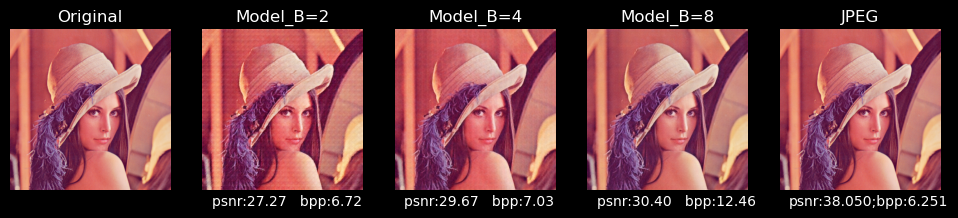

In [50]:
image_path='/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/data/lena.png'
output1=get_output(model_list,image_path)
image1 = Image.open(image_path).convert('RGB')
show_image(image1,output1)

torch.Size([1, 3, 512, 512])


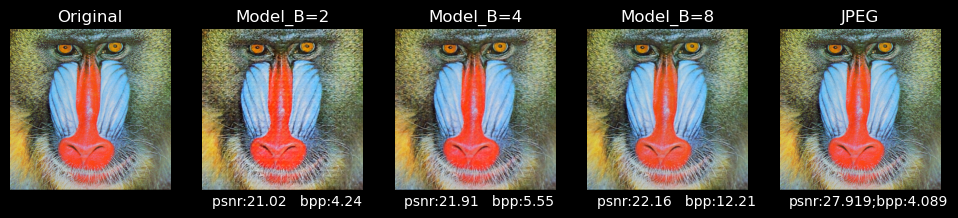

In [51]:
image_path='/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/data/baboon.png'
output2=get_output(model_list,image_path)
image2 = Image.open(image_path).convert('RGB')
show_image(image2,output2)

torch.Size([1, 3, 512, 512])


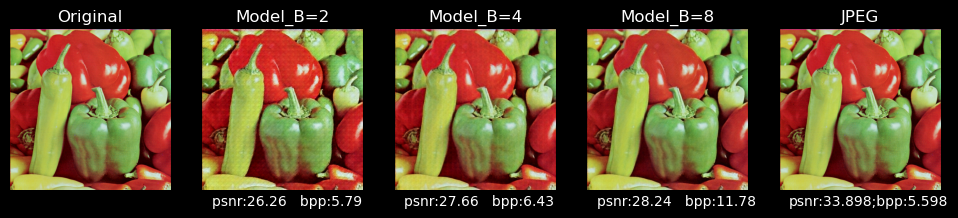

In [52]:
image_path='/home/xliao/tmp/PyTorch-Learned-Image-Compression-with-GMM-and-Attention/data/peppers.png'
output3=get_output(model_list,image_path)
image3 = Image.open(image_path).convert('RGB')
show_image(image3,output3)

## Plot


In [53]:
import statistics
output=[output1,output2,output3]

    
print(output1[0].keys())
# sorted_model_bpp = sorted(output, key=lambda k: k['model_bpp'], reverse=False)

def mean_out(stri):
    m1=statistics.mean([output1[0][stri],output2[0][stri],output3[0][stri]])
    m2=statistics.mean([output1[1][stri],output2[1][stri],output3[1][stri]])
    m3=statistics.mean([output1[2][stri],output2[2][stri],output3[2][stri]])
    
    res=[m1,m2,m3]
    return res

metrics={}
metrics['model_bpp']=mean_out('model_bpp')
metrics['jpeg_bpp']=mean_out('jpeg_bpp')
metrics['model_psnr']=mean_out('model_psnr')
metrics['jpeg_psnr']=mean_out('jpeg_psnr')
# print(metrics)

dict_keys(['recon_image', 'model_psnr', 'model_bpp', 'jpeg_recon', 'jpeg_psnr', 'jpeg_bpp'])


In [54]:
def show_plot(metrics):
    plt.style.use('default')
    l1=plt.plot(metrics['model_bpp'],metrics['model_psnr'],'ro-',label='compression model')
    l2=plt.plot(metrics['jpeg_bpp'],metrics['jpeg_psnr'],'g^-',label='jpeg')

    # plt.plot(x1,y1,'ro-',x2,y2,'g+-',x3,y3,'b^-')
    plt.title('PSNR comparison')
    plt.xlabel('Bit-rate [bpp]')
    plt.ylabel('PSNR [dB]')
    plt.legend()
    plt.show()


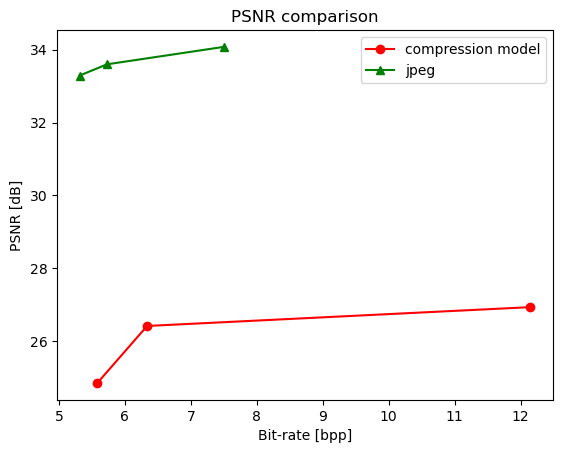

In [55]:
show_plot(metrics)